In [2]:
# compare the data/mc for cluster shape/position, variables used for BDT training
# to make sure the bdt is not just learning about the difference between data/mc

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [3]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2018
category = 0
version = '/v4/v4/'

data_path = '/mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/Data2018/v1/v16/normalized/'
sig_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p16/MC_Fall18/v1/v8/normalized/'
lumi = (5.632467289 +2.572903489 +1.685313225 +3.988453305 +3.068943620 +3.527270568 +8.609721915) * 1000
print("lumi is "+str(round(lumi/1000,2))+" fb-1")
fpath_bkg['mc'] = sig_path+"VH_HToSSTobbbb_ms55_1pb_weighted.root"
fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p15_Data2016_Data2017_Data2018-HighMET_goodLumi.root"
    

lumi is 29.09 fb-1


In [4]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p16/MC_Fall18/v1/v8/normalized/VH_HToSSTobbbb_ms55_1pb_weighted.root
[-0.11291613 -0.03889766 -0.03850869 -0.03132775 -0.02023993 -0.01858517
 -0.01851947  0.          0.01851947  0.01858517  0.02023993  0.03132775
  0.0381236   0.03850869  0.03889766  0.11291613]
(1200304,)
data /mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/Data2018/v1/v16/normalized/Run2_displacedJetMuonNtupler_V1p15_Data2016_Data2017_Data2018-HighMET_goodLumi.root
[29085.074]
(1114074,)


# load BDT

In [5]:
import pandas as pd
import pickle

bdt_model = 2
# if bdt_model == 0:
#     model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1.pickle', "rb" ))
# elif bdt_model == 1:
#     model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs.pickle', "rb" ))
# else:
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v1.pickle'
model = pickle.load(open(bdt_name, "rb" ))


In [7]:
%%time

start_t = time.time()
jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
npv = {}
npu = {}
nJets = {}
nJets_50gev = {}
jetPt = {}
jetPhi = {}
jetEta = {}
metPhi = {}
met = {}
jetMet_dPhiMin4 = {}

cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterZSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaPhiSpread = {}

cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterNStation = {}
cscRechitClusterXYSpread = {}
cscRechitClusterRSpread = {}


cscRechitCluster2IsoMuonVetoPt = {}
cscRechitCluster2IsoMuonVetoE = {}
cscRechitCluster2IsoMuonVetoEta = {}


bdt_score = {}

keys = ['mc', 'data']


for k in keys:
    if k[:2] == 'mc':
        T = tree_bkg['mc']
    else:
        T = tree_bkg['data']
        

    sel_cluster = np.abs(T.array('cscRechitCluster2Time')) < 12.5
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2IsoMuonVetoPt')) > 20)
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2MaxChamber')) > 12)
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) > 1)
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta'))<1.2)

    if 'mc' in k:
        sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP') == 0)

    print(k, "cluster selection efficiency:", np.count_nonzero(sel_cluster.flatten())/len(sel_cluster.flatten()))
    

# ########### BRANCHES ############
    sel_ev = sel_cluster.sum() ==1 
#     if 'mc' in k:
#         gLLP_decay_vertex_z = T.array('gLLP_decay_vertex_z')
#         gLLP_decay_vertex_r = T.array('gLLP_decay_vertex_r')


#         distance0 = np.sqrt(gLLP_decay_vertex_z[:,0]**2+gLLP_decay_vertex_r[:,0]**2)
#         distance1 = np.sqrt(gLLP_decay_vertex_z[:,1]**2+gLLP_decay_vertex_r[:,1]**2)
#         cond1 = np.logical_or(distance1<200, np.logical_or(gLLP_decay_vertex_z[:,1]>1100, gLLP_decay_vertex_r[:,1]>800))
#         cond0 = np.logical_or(distance0<200, np.logical_or(gLLP_decay_vertex_z[:,0]>1100, gLLP_decay_vertex_r[:,0]>800))
#         sel_ev = np.logical_and(sel_ev, np.logical_and(cond0, cond1))
    cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterZSpread[k] = T.array('cscRechitCluster2ZSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEtaSpread[k] = T.array('cscRechitCluster2EtaSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterRSpread[k] = T.array('cscRechitCluster2RSpread')[sel_cluster][sel_ev][:,0]


#     if k == 'mc':
#         cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread_phi0p5')[sel_cluster][sel_ev][:,0]
#         cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread_phi0p5')[sel_cluster][sel_ev][:,0]
#         cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread_phi0p5')[sel_cluster][sel_ev][:,0]
#         cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread_phi0p5')[sel_cluster][sel_ev][:,0]



    cscRechitClusterX[k] = T.array('cscRechitCluster2X')[sel_cluster][sel_ev][:,0]
    cscRechitClusterY[k] = T.array('cscRechitCluster2Y')[sel_cluster][sel_ev][:,0]
    cscRechitClusterZ[k] = T.array('cscRechitCluster2Z')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEta[k] = T.array('cscRechitCluster2Eta')[sel_cluster][sel_ev][:,0]
    cscRechitClusterPhi[k] = T.array('cscRechitCluster2Phi')[sel_cluster][sel_ev][:,0]

    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterNStation[k] = T.array('cscRechitCluster2NStation')[sel_cluster][sel_ev][:,0]
    cscRechitCluster2IsoMuonVetoPt[k] = T.array('cscRechitCluster2IsoMuonVetoPt')[sel_cluster][sel_ev][:,0]
    cscRechitCluster2IsoMuonVetoE[k] = T.array('cscRechitCluster2IsoMuonVetoE')[sel_cluster][sel_ev][:,0]
    cscRechitCluster2IsoMuonVetoEta[k] = T.array('cscRechitCluster2IsoMuonVetoEta')[sel_cluster][sel_ev][:,0]


   ##### cluster-level variables ##### 
#     if bdt_model == 0:
        
#         bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
#          'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
#          'cscRechitClusterNStation':cscRechitClusterNStation[k],
#          'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
#          'cscRechitClusterX':cscRechitClusterX[k],
#          'cscRechitClusterY':cscRechitClusterY[k],
#          'cscRechitClusterZ':cscRechitClusterZ[k],
#         }
#     elif bdt_model == 1:
#         bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
#          'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
#          'cscRechitClusterNStation':cscRechitClusterNStation[k],
#          'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
#          'cscRechitClusterX':np.abs(cscRechitClusterX[k]),
#          'cscRechitClusterY':np.abs(cscRechitClusterY[k]),
#          'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
#         }
    if 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread' in bdt_name:
        bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
        'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
        'cscRechitClusterYSpread':cscRechitClusterYSpread[k],
        'cscRechitClusterXYSpread':cscRechitClusterXYSpread[k],
        'cscRechitClusterPhi':np.abs(cscRechitClusterPhi[k]),
        'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
        'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        }
    else:
        print('BDT NOT FOUND')


##### bdt variables ####
 
    
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
    print(len(bdt_score[k]) == np.count_nonzero(sel_ev))

    met[k] = T.array('met') [sel_ev]
    metPhi[k] = T.array('metPhi')[sel_ev]
    npv[k] = T.array('npv')[sel_ev]
    weight[k] = T.array('weight')[sel_ev]*lumi
    pileupWeight[k] = T.array('pileupWeight')[sel_ev]
    if k == 'data':
        pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
        weight[k] = weight[k] * 0.0 + 1.0
    

mc cluster selection efficiency: 0.0018524317968292986
True
data cluster selection efficiency: 0.0013982655041780542
True
CPU times: user 8.45 s, sys: 560 ms, total: 9.01 s
Wall time: 8.65 s


# shape comparison

In [102]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

# Plotting ncsc
start_t = time.time()

logy = 0

rt.gStyle.SetOptFit(1011)
# var = [cscSegClusterX, cscSegClusterY, cscSegClusterZ, cscSegClusterXSpread, cscSegClusterYSpread, cscSegClusterZSpread, cscSegClusterEtaPhiSpread, cscSegClusterNStation]
# title = ['cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'cluster X spread [cm]', 'cluster Y spread [cm]', 'cluster Z spread [cm]', 'cluster #eta-#phi spread', 'N_{station}']
# bins = [[25,0,700],[25,0,700],[25,500,1100],[25,0,90], [25,0,90], [25,0,300], [25,0,0.1], [5,0,5]]
# names = ['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterNStation']

var = [cscSegClusterX, cscSegClusterY, cscSegClusterZ, cscSegClusterNStation]
title = ['cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'N_{station}']
bins = [[25,0,700],[25,0,700],[25,500,1100],[5,0,5]]
names = ['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterNStation']



key_plot = ['mc_mx55_bkg','data']

for j,v in enumerate(var):
    if not j == 3:continue
    print(j)
    leg = rt.TLegend(0.55,0.80,0.87,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    for i,k in enumerate(keys):
        h[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = pileupWeight[k]* weight[k])
#         h[k] = create_TH1D( cscSegClusterYSpread[k], axis_title=['cluster Y spread [cm]', 'Events'], name=k, binning=[25,0,90], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterZSpread[k], axis_title=['cluster Z spread [cm]', 'Events'], name=k, binning=[25,0,300], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterEtaPhiSpread[k], axis_title=['cluster #eta-#phi spread', 'Events'], name=k, binning=[25,0,0.1], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterNStation[k], axis_title=['N_{station}', 'Events'], name=k, binning=[5,0,5], weights = pileupWeight[k]* weight[k])
        h[k].SetLineColor(std_color_list[i])
        if 'bkg' in k: h[k].SetLineColor(std_color_list[i-1])
        if 'data' in k: h[k].SetLineColor(std_color_list[i-3])
        leg.AddEntry(h[k],k)
        if logy: h[k].SetMaximum(h[k].GetMaximum()*10)
        else: h[k].SetMaximum(h[k].GetMaximum()*1.5)
    #     h[str(i)].SetMinimum(0.1)
        if 'signal' in k: h[k].SetLineStyle(2)
        h[k].GetXaxis().SetLabelSize(0.04)
        h[k].DrawNormalized('same hist')
        h[k].Scale(1./h[k].Integral())
#     c = make_ratio_plot([h['mc_mx55_bkg'],h['data']], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,3])

    c.SetRightMargin(0.05)
    if logy: c.SetLogy()
#     leg.Draw()

    c.Draw()
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_eta2p1_ME1112veto/"+names[j]+".png")
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot/"+names[j]+".png")

# print(time.time()-start_t)

NameError: name 'cscSegClusterX' is not defined

# with ratio plot

data 1211
mc 627


Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


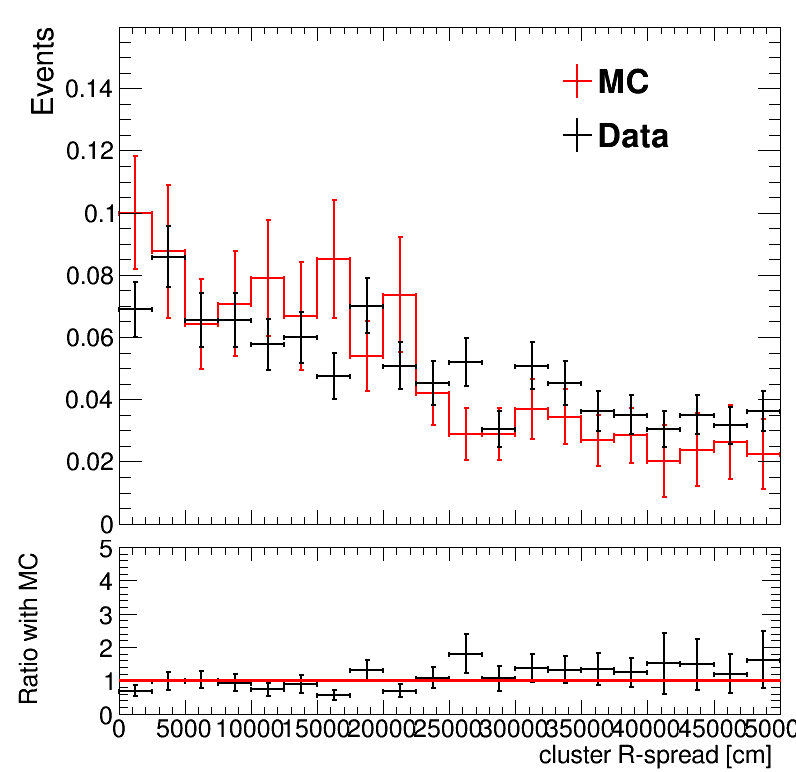

In [18]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import os

# Plotting ncsc
start_t = time.time()

logy = 0

rt.gStyle.SetOptFit(1011)

dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_XYspread_v1_muonShower/'
# os.makedirs(dir_name)
var = [bdt_score, cscRechitClusterEta, cscRechitClusterPhi, cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, \
   cscRechitClusterEtaSpread, cscRechitClusterPhiSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterRSpread, cscRechitClusterXSpread, cscRechitClusterYSpread, cscRechitClusterZSpread, \
       cscRechitClusterXYSpread, cscRechitClusterNStation, cscRechitCluster2IsoMuonVetoPt, cscRechitCluster2IsoMuonVetoE, cscRechitCluster2IsoMuonVetoEta]
title = ['BDT score', 'cluster #eta', 'cluster #phi', 'cluster X [cm]','cluster Y [cm]','cluster Z [cm]', \
         'cluster #eta spread', 'cluster #phi spread', 'cluster #eta-#phi spread', 'cluster R-spread [cm]', 'cluster X-spread [cm]','cluster Y-spread [cm]','cluster Z-spread [cm]',\
          'cluster XY-spread [cm]','N_{station}', 'matched muon pT [GeV]', 'matched muon E [GeV]', 'matched muon #eta']
bins = [[10,0,1], [10,1,1.2],[10,0,3.2],[15,0,700],[15,0,700], [25,600,1100], 
        [25,0,0.2], [25,0,0.1],[25,0,0.1], [20,0,50000], [20,0,100], [20,0,100], [20,0,100],
       [20,0,60],[5,0,5], [10,0,500], [10,0,500], [25,0.8,1.6]]


names = ['bdt_score', 'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', \
   'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterRSpread', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', \
       'cscRechitClusterXYSpread', 'cscRechitClusterNStation', 'cscRechitCluster2IsoMuonVetoPt', 'cscRechitCluster2IsoMuonVetoE', 'cscRechitCluster2IsoMuonVetoEta']
key_plot = ['data', 'mc']


for j,v in enumerate(var):
    if not j == 9:continue
    leg = rt.TLegend(0.55,0.80,0.87,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    ###########
    # reweight
    ##########
    h = {}
    reweight_index = 14
    h['mc_reweight'] = create_TH1D( np.abs(var[reweight_index]['mc']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = pileupWeight['mc']* weight['mc'])
    h['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = pileupWeight['data']* weight['data'])
    h['data_reweight'].Divide(h['mc_reweight'])
    reweight = []
    for m in range(len(v['mc'])):
        reweight.append(h['data_reweight'].GetBinContent(h['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index]['mc'])[m])))
    
    maximum = 0
    for i,k in enumerate(key_plot):
        total_weight = pileupWeight[k]* weight[k]
#         if k == 'mc': total_weight = total_weight * reweight
        h[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights =total_weight)
        h[k].SetLineColor(std_color_list[i])
        maximum = max(maximum, h[k].GetMaximum())
        if logy: h[k].SetMaximum(maximum*10)
        else: h[k].SetMaximum(maximum*10)
    #     h[str(i)].SetMinimum(0.1)
        if 'signal' in k: h[k].SetLineStyle(2)
        h[k].GetXaxis().SetLabelSize(0.04)
#         h[k].DrawNormalized('same hist')
#         if names[j] == 'bdt_score': print('bdt efficiency', k, np.count_nonzero(v[k]>bdt_cut)/len(v[k]))
        print(k, len(v[k]))
        h[k].Scale(1./h[k].Integral())
    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,5], draw_opt = ['hist E1','E1'])

    c.SetRightMargin(0.2)
    if logy: c.SetLogy()

    c.Draw()
#     c.SaveAs(dir_name+names[j]+"_withRatio.png")

